# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: Leon Löpert
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [101]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

torch.manual_seed(42) # Set manual seed

In [3]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [83]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # This randomly flips the input images horizontally with a probability of 0.5, which helps in augmenting the training data and introducing some variation.
    transforms.ToTensor(),# This converts the input image into a tensor, which is the preferred format for most machine learning frameworks.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) #  This normalizes the tensor values by subtracting the mean and dividing by the standard deviation. The given mean and standard deviation values (0.4914, 0.4822, 0.4465) and (0.2023, 0.1994, 0.2010) respectively, correspond to the means and standard deviations of the three color channels of the CIFAR-10 dataset. Normalization helps in improving the convergence and stability of the training process.
])

test_transforms = transforms.Compose([
    transforms.ToTensor(), # also divides by 255 if image data are assumed
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])



In [61]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# The transformations specified in train_transforms are applied when you access the data through the train_dataset object using its __getitem__ method. This means that the transformations are applied dynamically at runtime when you retrieve an image from the dataset using indexing.

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above. 

Files already downloaded and verified
Files already downloaded and verified


In [88]:
# Ignore me. I was just testing around to get a feeling for the data.
#print(type(train_dataset))
#print(train_dataset.data.shape) # (number of images, height: 32px, width: 32px,color channels RGB) 
#print(test_dataset.data.shape)

#bla = datasets.CIFAR10(root='./data', train=True, download=True, transform = test_transforms)
#print(bla.__getitem__(0))
#bla2 = datasets.CIFAR10(root='./data', train=True, download=True)
#print(bla2.__getitem__(0))
#print(train_dataset.__getitem__(0)[0][0])
#print(train_dataset.data.mean(axis = (0,1,2))) # 255 normalizes each color channel


<class 'torchvision.datasets.cifar.CIFAR10'>
(50000, 32, 32, 3)
(10000, 32, 32, 3)
Files already downloaded and verified
(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
 

In [240]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
 

In the context of image data, augmentations refer to a set of operations or transformations applied to the images to create variations or modifications of the original data. These augmentations are typically used in the training phase of a machine learning model to increase the diversity and variability of the training data, which can help improve the model's generalization and robustness.

Common augmentations for image data include:

Random flips: Images are randomly flipped horizontally or vertically.
Random rotations: Images are randomly rotated by a certain angle.
Random crops: Random portions of the image are cropped.
Random translations: Images are randomly shifted horizontally or vertically.
Color jitter: Random changes in brightness, contrast, saturation, or hue are applied.
These augmentations introduce variations in the appearance of the images without changing their underlying label or content. By applying these augmentations to the training data, the model can learn to be more robust to different orientations, scales, and other variations that may be present in the real-world data.

When plotting images with their labels after augmentations, it means visualizing the transformed images along with their corresponding labels (y-values). This allows you to inspect how the augmentations have modified the original images while preserving their label information.

tensor([[[ 0.1491,  0.2461,  0.5950,  ...,  0.6725,  0.7888,  0.6531],
         [ 0.2654,  0.3430,  0.6725,  ...,  0.4981,  0.5562,  0.4787],
         [ 0.2848,  0.1685,  0.5368,  ...,  0.3624,  0.3817,  0.3042],
         ...,
         [-0.1610, -0.3936, -0.7620,  ..., -1.1884, -1.2466, -0.8395],
         [-0.4130, -0.3743, -0.6263,  ..., -1.1303, -0.9946, -0.8783],
         [-0.7038, -0.7426, -0.5875,  ..., -1.0527, -0.9170, -0.9946]],

        [[ 1.1021,  1.1218,  1.2791,  ...,  1.3184,  1.2988,  1.2004],
         [ 1.0038,  1.0431,  1.2201,  ...,  1.2988,  1.2988,  1.1808],
         [ 0.9054,  0.9251,  1.1218,  ...,  1.2201,  1.1808,  1.0234],
         ...,
         [ 0.8858,  0.6891,  0.5121,  ..., -0.6679, -0.6876, -0.2156],
         [ 0.7088,  0.7481,  0.6104,  ..., -0.5302, -0.3926, -0.2942],
         [ 0.3548,  0.3351,  0.4924,  ..., -0.3139, -0.2352, -0.3926]],

        [[-0.8557, -0.7386, -0.3679,  ...,  0.3735,  0.5881,  0.5491],
         [-0.6606, -0.6020, -0.3289,  ..., -0

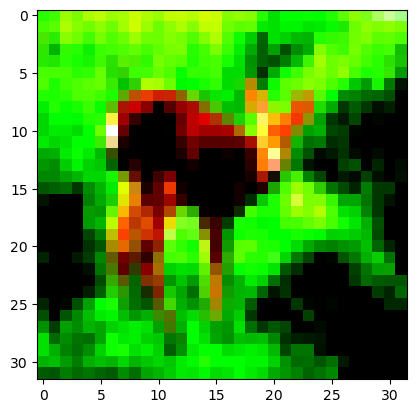

In [219]:
x, y = next(iter(train_loader))
print(x[0])
print(x.shape)
x = x[0]  # Select the first image from the batch

# Reshape the tensor to (32, 32, 3)
x = x.permute(1, 2, 0)
plt.imshow(x)
plt.show()

In [198]:

def show_batch(dl):
    # Get a batch of augmented images and labels
    images, labels = next(iter(dl))

    # Create a grid of images
    grid = torchvision.utils.make_grid(images[:100], nrow=10, padding=12, normalize=True) # Normalize result is counter intuitive...
    # In the case of the CIFAR-10 dataset, the pixel values represent the intensity of the color channels (red, green, blue) in the range of 0-255. 
    # By normalizing the pixel values, they are scaled down to a range of 0-1, which can help improve the visual appearance and contrast of the images.
    # Without normalization, the pixel values remain in the original range, which can result in images that appear darker or with less contrast when visualized in a grid. 
    # The absence of normalization can make it more challenging to interpret and compare the images in the grid, especially when there are variations in the brightness or contrast levels across different images.
    grid = np.transpose(grid, (1, 2, 0))  # Convert to channel-last format for plotting; otherwise:  Invalid shape (3, 452, 452) for image data
    
    # The purpose of normalization is to bring the pixel values of the images to a standardized range that is more suitable for machine learning models. It helps in improving the convergence and stability of the training process.
    
    #After creating the image grid using make_grid, the resulting tensor has the shape (C, H, W), where C represents the number of channels (in this case, 3 for RGB), H represents the height of the grid, and W represents the width of the grid.
    #However, to plot the image grid using imshow from matplotlib, the expected shape is (H, W, C), i.e., the channels should be the last dimension.

    # Define class labels
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Plot the grid of images
    plt.figure(figsize=(16, 16))
    plt.imshow(grid)
    plt.axis('off')

    # Calculate label position offsets
    x_offset = 28
    y_offset = 51  # Fixed vertical offset below the grid

    # Display the labels on top of each image
    for i in range(100):
        x = i % 10 * 44 + x_offset
        y = (i // 10) * 44 + y_offset
        plt.text(x, y, class_labels[labels[i]], color='red', backgroundcolor='white', fontsize=12, ha='center')
        
    plt.show()


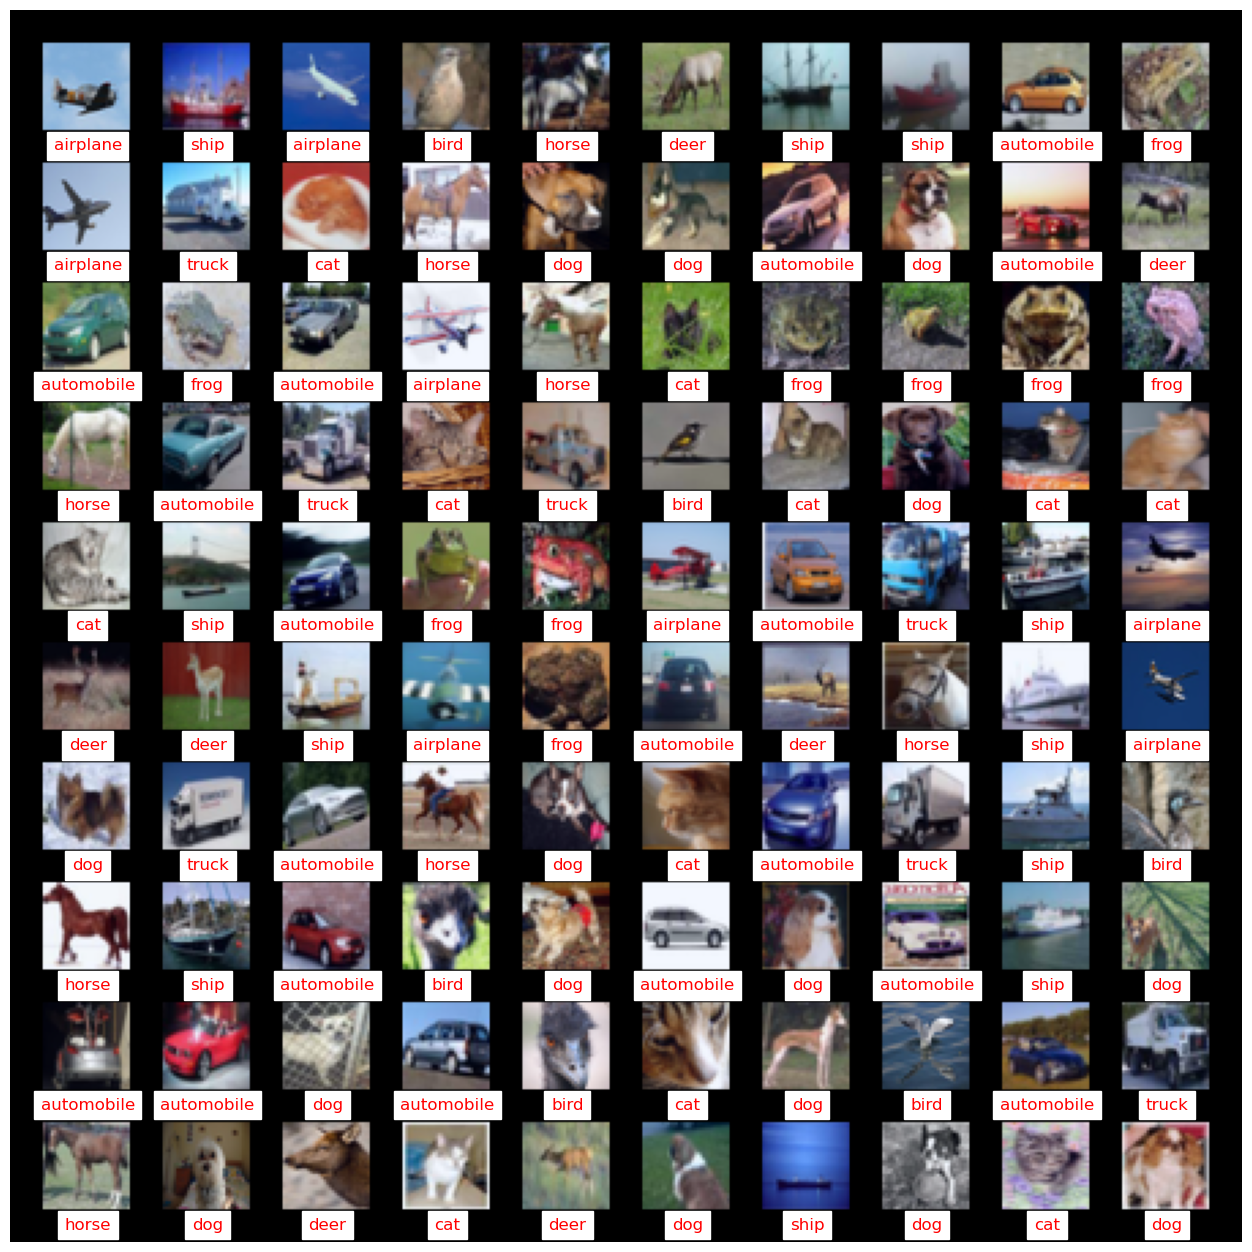

In [199]:
show_batch(train_loader)

In [224]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [ ]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct/total

In [235]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Method to train the model."""
    
    model.train()  # Set the model in training mode
    train_loss = 0.0
    correct = 0
    total = 0
    
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        _, predicted = torch.max(y_pred.data, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
        
        # Update progress bar
        master_bar.child.comment = f"Training Loss: {train_loss / (i+1):.4f} | Training Accuracy: {correct / total:.4f}"
    
    return train_loss / len(dataloader), correct / total

    # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            y_pred = model(x)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
            
            # Update progress bar
            master_bar.child.comment = f"Validation Loss: {val_loss / (i+1):.4f} | Validation Accuracy: {correct / total:.4f}"
    
    return val_loss / len(dataloader), correct / total

In [234]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """Method to run the training procedure."""
    
    train_losses = []  # List to store the training losses
    val_losses = []  # List to store the validation losses
    train_accs = []  # List to store the training accuracies
    val_accs = []  # List to store the validation accuracies
    
    model.to(device)  # Move the model to the device
    
    master_bar = trange(num_epochs, desc="Epochs", unit="epoch")
    
    for epoch in master_bar:
        master_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, master_bar)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
    return train_losses, val_losses, train_accs, val_accs
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

In [226]:
def calc_confusion_values(dataloader, model, device):
    """Method to compute the confusion values on the validation set."""
    
    # Initialize the confusion matrix
    num_classes = len(dataloader.dataset.classes)
    confusion_matrix = torch.zeros(num_classes, num_classes).to(device)
    
    model.eval()  # Set the model in evaluation mode
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                true_label = labels[i]
                predicted_label = predicted[i]
                confusion_matrix[true_label][predicted_label] += 1
    
    return confusion_matrix


## Logistic Regression   

In [229]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # Define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # Flatten the input to a suitable size for the initial layer
        x = x.view(x.size(0), -1)
        
        # Run the data through the layer
        outputs = self.linear(x)
        return outputs


In [248]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
linear_regression = LR(3072, 1)  # Replace input_dim and output_dim with appropriate values
linear_regression.to(device)  # Move the model to the desired device
linear_regression.train()  # Set the model to train mode



LR(
  (linear): Linear(in_features=3072, out_features=1, bias=True)
)

In [245]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [249]:
# TODO: define the loss function
loss_fn = torch.nn.CrossEntropyLoss()


In [250]:
num_epochs = 20
## TODO: run training over 20 epochs
train_losses, val_losses = run_training(linear_regression, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)


Epoch 1/20:   0%|          | 0/20 [00:01<?, ?epoch/s]
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity

        super().__init__()
        
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input

        return 

In [ ]:
## TODO: Define network, put it to device and train mode


In [ ]:
## TODO: Define optimizer and loss functions


In [ ]:
## TODO: Train the MLP over 20 epochs


## Add L2 regularisation

In [ ]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength

In [ ]:
## TODO: Retrain new model with regularization over 20 epochs

## LeNet5

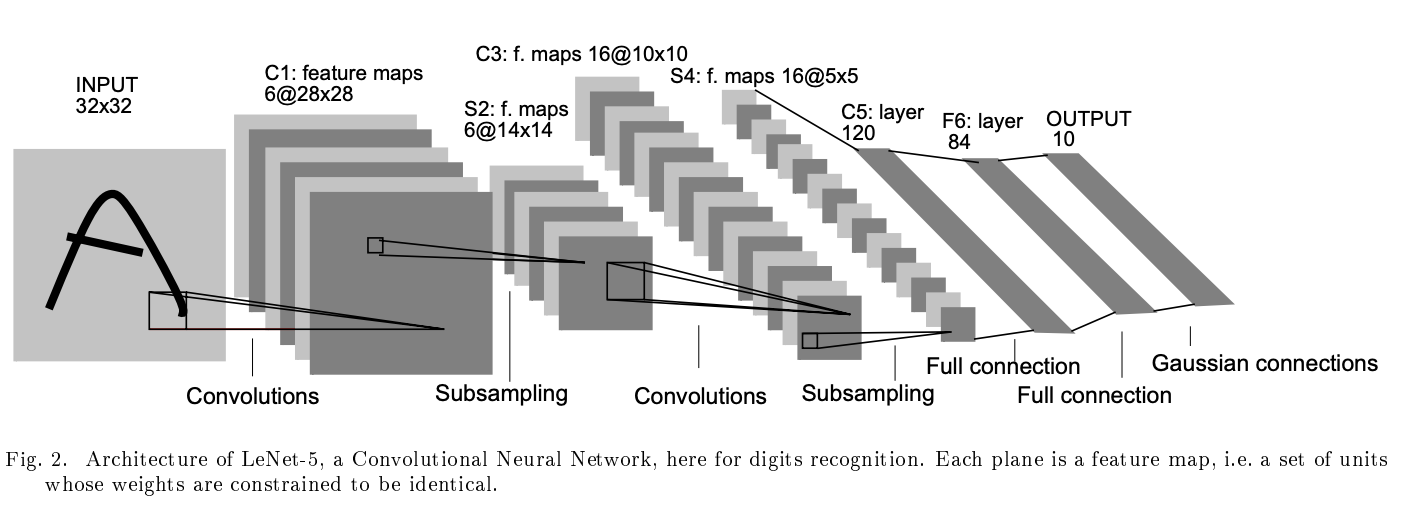

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [6]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
## TODO: define network, put it to the device and train mode


In [ ]:
## TODO: define loss function and optimisers


In [ ]:
## TODO: train with 20 epochs
num_epochs = 20


## Analysis 

In [ ]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

In [ ]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?

In [ ]:
## TODO: Plot the confusion matrix for LeNet5


## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
